In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [3]:
# Entire Dataset
df = pd.read_csv("./Data/zozo_Context_80items.csv", index_col = 0)
df["user_type"] = df["user_feature_0"] + df["user_feature_1"] + df["user_feature_2"] + df["user_feature_3"] 

### Helper functions

In [4]:
# Extract just the clicks information from the data
def resDictToDfClicks(resDict, method):
    if method == "TS":
        DFclicks = pd.DataFrame(np.vstack([resDict[key][2][:, 1] for key in resDict.keys()]).T)
    elif method == "Rand" or method == "UCB":
        DFclicks = pd.DataFrame(np.vstack([resDict[key][:, 1] for key in resDict.keys()]).T)
    DFclicks["avg"] = DFclicks.mean(axis = 1)
    DFclicks["cumlsum"] = DFclicks.avg.cumsum()
    DFclicks["sd"] = DFclicks.iloc[:, 0:10].cumsum().std(axis = 1)
    DFclicks["lb"] = DFclicks["cumlsum"] - DFclicks["sd"] * 1.96 
    DFclicks["ub"] = DFclicks["cumlsum"] + DFclicks["sd"] * 1.96 
    
    return DFclicks

# Extract just the arms information from the data (fairness-to-arms)
def resDictToDfArms(resDict, method):
    if method == "TS":
        DFarms = pd.DataFrame(np.vstack([resDict[key][2][:, 0].astype("int64") for key in resDict.keys()]).T)
    elif method == "Rand" or method == "UCB":
        DFarms = pd.DataFrame(np.vstack([resDict[key][:, 0].astype("int64") for key in resDict.keys()]).T)

    return DFarms

# Extract just the user index information from the data (fairness-to-arms)
def resDictToDfIndex(resDict, method):
    if method == "TS":
        DFindex = pd.DataFrame(np.vstack([resDict[key][2][:, 2].astype("int64") for key in resDict.keys()]).T)
    elif method == "Rand" or method == "UCB":
        DFindex = pd.DataFrame(np.vstack([resDict[key][:, 2].astype("int64") for key in resDict.keys()]).T)

    return DFindex

### Plotting functions

In [15]:
myStyle = r"C:\Users\misko\miniconda3\Lib\site-packages\matplotlib\mpl-data\stylelib\nicePlots.mplstyle"

def plotClicks(DFclicks, method, color):
    with plt.style.context(myStyle):
        fig, ax = plt.subplots(1, 1, figsize = (8, 6))

        ax.plot(DFclicks.cumlsum, 
                color = color, label = "Average Cumulative Sum")
        ax.fill_between(DFclicks.index, DFclicks.ub, DFclicks.lb, alpha = 0.4, 
                        color = color, label = "95% Confidence Interval")
        ax.set_ylim(0, 145)
        ax.set_xlabel("Items Shown")
        ax.set_ylabel("Cumulative Clicks")
        ax.legend(loc = "lower right")
        ax.set_title(f"{method}")

        plt.savefig(f"{method.replace(' ', '_')}_Avg.png")
        
        plt.show()
        
def plotFairnessArms(DFarms, method, color):
    armsShownCounts = np.array([np.bincount(DFarms.iloc[:, [i]].values[:, 0]) for i in range(10)])
    armsShownMeans = armsShownCounts.mean(axis = 0)
    armsShownStds = armsShownCounts.std(axis = 0)
    
    with plt.style.context(myStyle):
        fig, ax = plt.subplots(1, 1, figsize = (20, 5))

        ax.bar(range(armsShownMeans.shape[0]), armsShownMeans, width = 1, color = color)
        ax.set_xticks([i for i in range(0, 237, 5)])
        ax.axes.margins(0.01)
        ax.set_title(f"Average Number of Impressions per Arm ({method})", size = 18, pad = 30)
        ax.set_xlabel("Arms")
        ax.set_ylabel("Impressions")
        
        plt.savefig(f"{method.replace(' ', '_')}_Arm_Fairness.png")
        
        plt.show()

In [28]:
armsShownCounts = np.array([np.bincount(THarms.iloc[:, [i]].values[:, 0]) for i in range(10)])
np.argsort(armsShownCounts.mean(axis = 0))

TypeError: _argsort_dispatcher() got an unexpected keyword argument 'return_index'

In [ ]:
np.sort()

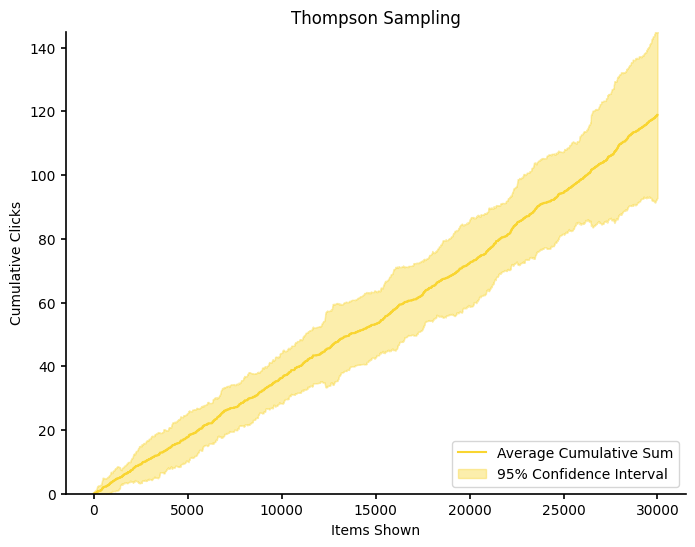

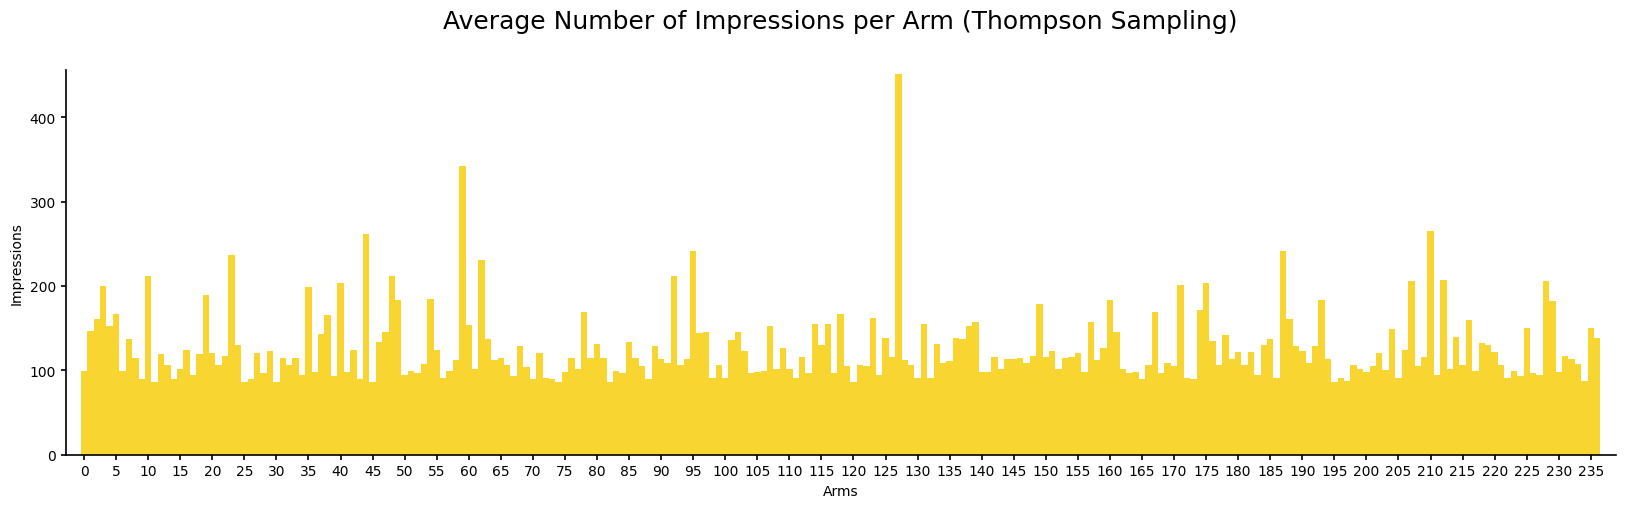

In [16]:
method = "Thompson Sampling"

with open("./MAB_Results/ResultDictTH", "rb") as f:
    THDict = pickle.load(f)
    
THclicks = resDictToDfClicks(THDict, "TS")
THarms = resDictToDfArms(THDict, "TS")

plotClicks(THclicks, method, "#f9d531")
plotFairnessArms(THarms, method, "#f9d531")

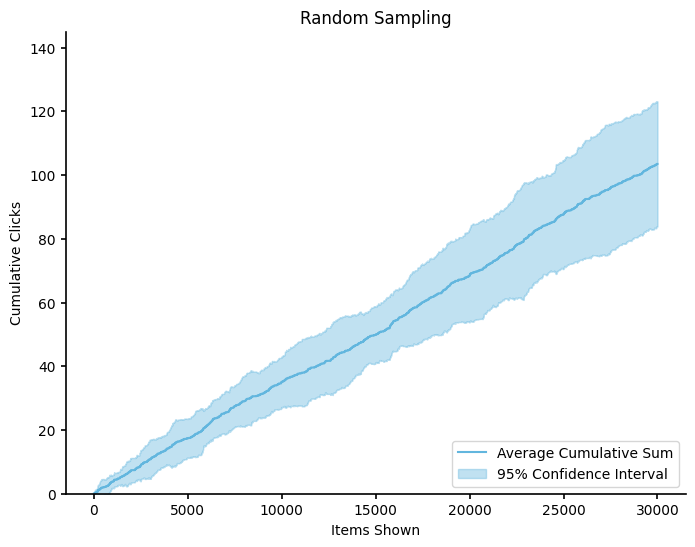

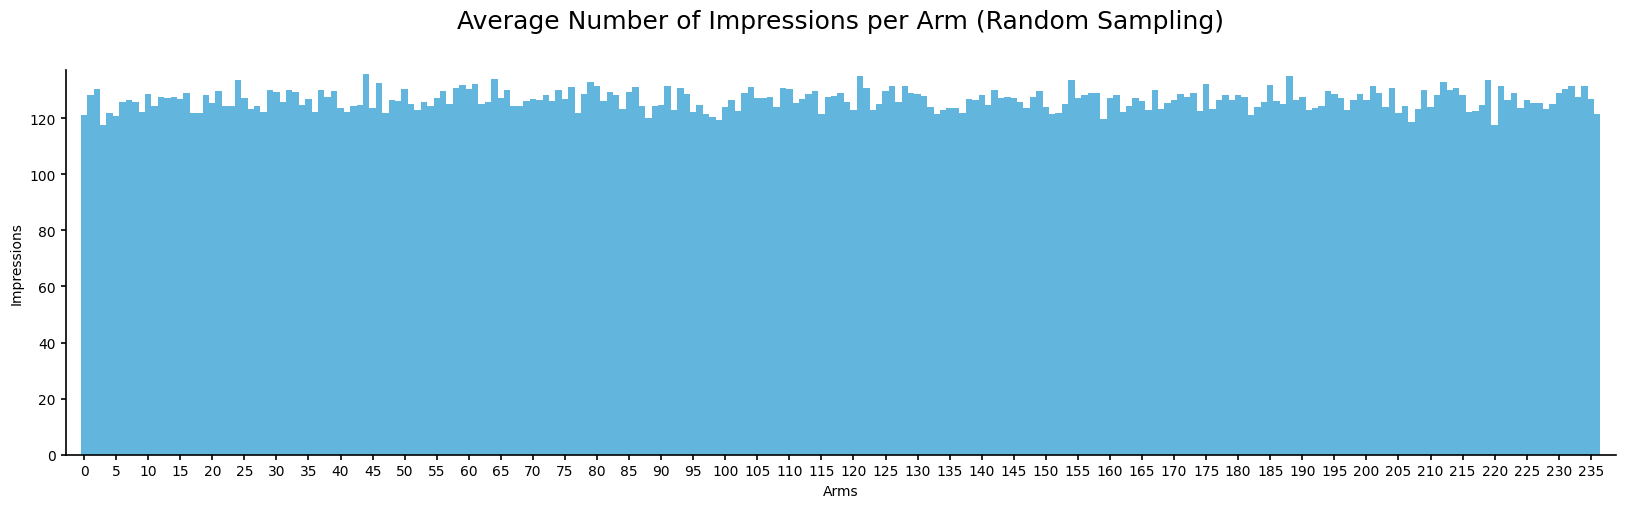

In [17]:
method = "Random Sampling"

with open("./MAB_Results/ResultDictRandom", "rb") as f:
    RandDict = pickle.load(f)
    
Randclicks = resDictToDfClicks(RandDict, "Rand")
Randarms = resDictToDfArms(RandDict, "Rand")

plotClicks(Randclicks, method, "#62b6de")
plotFairnessArms(Randarms, method, "#62b6de")

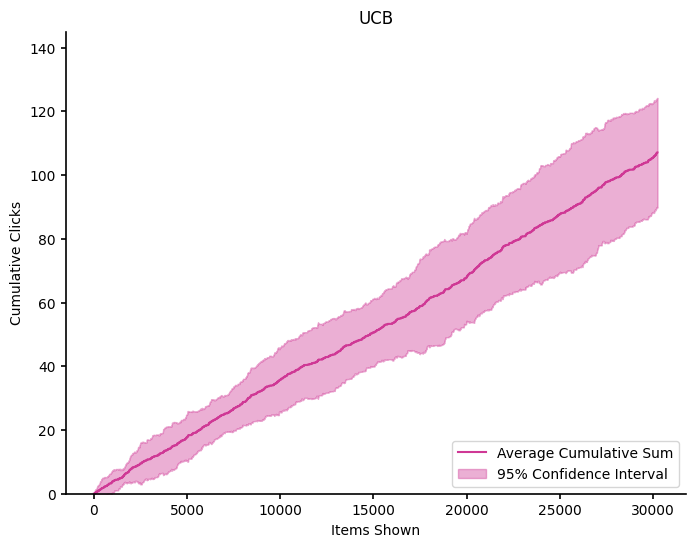

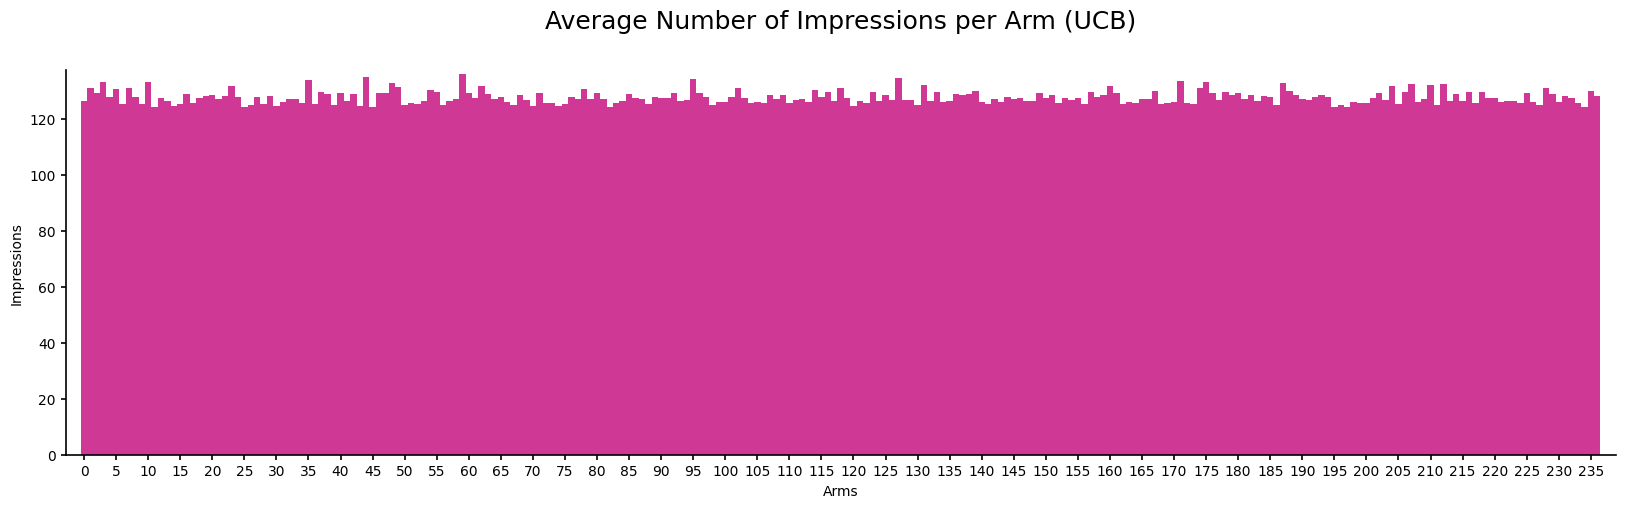

In [18]:
method = "UCB"

with open("./MAB_Results/ResultDictUCB", "rb") as f:
    UCBDict = pickle.load(f)
    
UCBclicks = resDictToDfClicks(UCBDict, method)
UCBarms = resDictToDfArms(UCBDict, method)

plotClicks(UCBclicks, method, "#cf3895")
plotFairnessArms(UCBarms, method, "#cf3895")

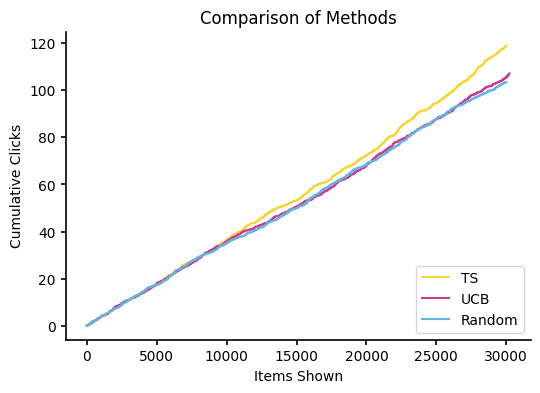

In [554]:
with plt.style.context(myStyle):
    fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    
    # TS
    ax.plot(THclicks.cumlsum, 
            color = "#f9d531", label = "TS")

    #UCB
    ax.plot(UCBclicks.cumlsum, 
            color = "#cf3895", label = "UCB")
    
    #Random
    ax.plot(Randclicks.cumlsum, 
            color = "#62b6de", label = "Random")    
    
    ax.set_xlabel("Items Shown")
    ax.set_ylabel("Cumulative Clicks")
    ax.legend(loc = "lower right")
    ax.set_title("Comparison of Methods")

    plt.savefig("Methods_Comparison.png")

    plt.show()

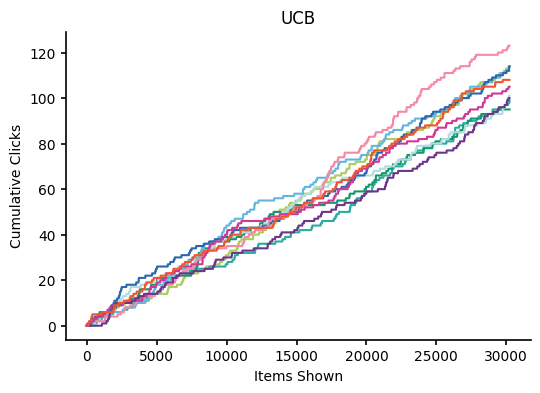

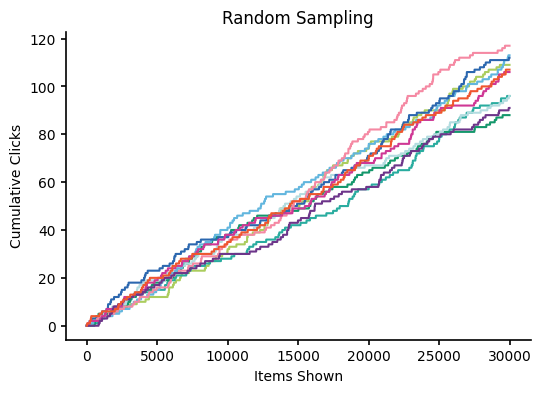

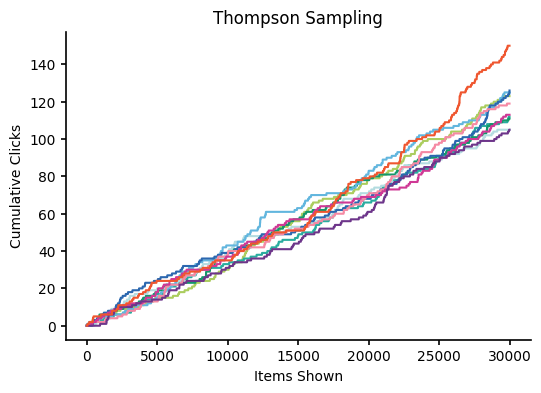

In [553]:
def plotAllRuns(DFDict, method):
    SimDFs = pd.DataFrame()

    with plt.style.context(myStyle):

        fig, ax = plt.subplots(1, 1, figsize = (6, 4))

        for key, value in DFDict.items():
            if method == "Thompson Sampling":
                resultSim = DFDict[key][2]
            else:
                resultSim = DFDict[key]
            resultSimDF = pd.DataFrame(resultSim, columns=['arm','click', "index"])
            PS = resultSimDF['click'].cumsum()
            PS.name = 'click{}'.format(key)
            SimDFs = pd.concat([SimDFs, resultSimDF['click'], PS],axis=1)

            ax.plot(resultSimDF.click.cumsum())

        ax.set_xlabel("Items Shown")
        ax.set_ylabel("Cumulative Clicks")
        ax.set_title(f"{method}")

        plt.savefig(f"{method.replace(' ', '_')}_All_Runs.png")
        
plotAllRuns(UCBDict, "UCB")
plotAllRuns(RandDict, "Random Sampling")
plotAllRuns(THDict, "Thompson Sampling")

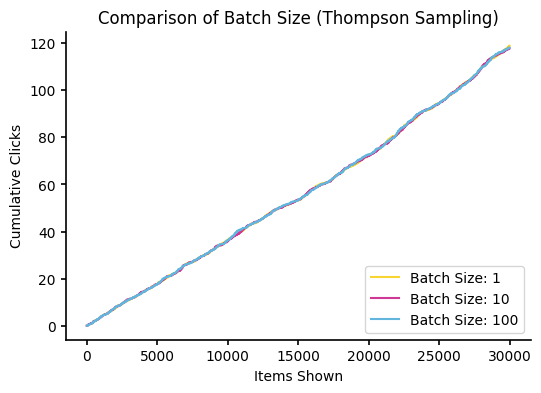

In [557]:
method = "TS"

with open("./MAB_Results/ResultDictTHBatchingSize10", "rb") as f:
    TH10Dict = pickle.load(f)
TH10clicks = resDictToDfClicks(TH10Dict, method)

with open("./MAB_Results/ResultDictTHBatchingSize100", "rb") as f:
    TH100Dict = pickle.load(f)
TH100clicks = resDictToDfClicks(TH100Dict, method)

with plt.style.context(myStyle):
    fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    
    # TS Batch = 1
    ax.plot(THclicks.cumlsum, 
            color = "#f9d531", label = "Batch Size: 1")

    #TS Batch = 10
    ax.plot(TH10clicks.cumlsum, 
            color = "#cf3895", label = "Batch Size: 10")
    
    #TS Batch = 100
    ax.plot(TH100clicks.cumlsum, 
            color = "#62b6de", label = "Batch Size: 100")    
    
    ax.set_xlabel("Items Shown")
    ax.set_ylabel("Cumulative Clicks")
    ax.legend(loc = "lower right")
    ax.set_title("Comparison of Batch Size (Thompson Sampling)")

    plt.savefig("TS_Batch_Size_Comparison.png")

    plt.show()

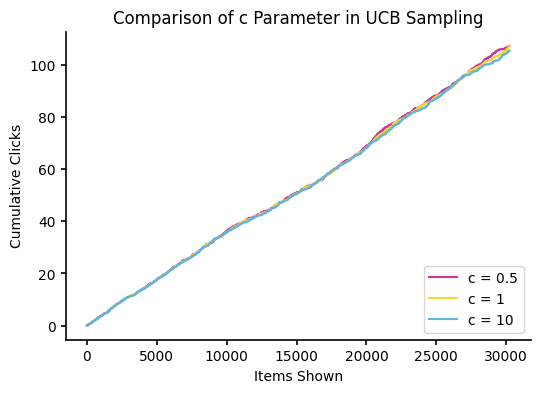

In [13]:
method = "UCB"

with open("./MAB_Results/ResultDictUCB_C05", "rb") as f:
    UCB05Dict = pickle.load(f)
UCB05clicks = resDictToDfClicks(UCB05Dict, method)

with open("./MAB_Results/ResultDictUCB_C10", "rb") as f:
    UCB10Dict = pickle.load(f)
UCB10clicks = resDictToDfClicks(UCB10Dict, method)

with plt.style.context(myStyle):
    fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    
    #UCB c = 0.5
    ax.plot(UCB05clicks.cumlsum, 
            color = "#cf3895", label = "c = 0.5")
    
    # UCB c = 1
    ax.plot(UCBclicks.cumlsum, 
            color = "#f9d531", label = "c = 1")

    #UCB c = 10
    ax.plot(UCB10clicks.cumlsum, 
            color = "#62b6de", label = "c = 10")   
    
    ax.set_xlabel("Items Shown")
    ax.set_ylabel("Cumulative Clicks")
    ax.legend(loc = "lower right")
    ax.set_title("Comparison of c Parameter in UCB Sampling")

    plt.savefig("UCB_c_Comparison.png")

    plt.show()

### Helper functions for Fairness

In [464]:
def getFeatureValues(DFindex):
    output = []
    for f in range(4):
        DFfeature = pd.DataFrame(np.array([df.loc[DFindex[i], f"user_feature_{f}"] for i in range(10)])).T
        output.append(DFfeature)
        
    return output

def wrangleFeatureCounts(DFfeature):
    featureCounts = pd.DataFrame([np.unique(DFfeature.iloc[:, i].values, return_counts = True)[1] 
                                  for i in range(10)]).T
    featureCounts["avg"] = featureCounts.mean(axis = 1)
    featureCounts["sd"] = featureCounts.std(axis = 1)
    
    return featureCounts

def calcFairnessForFeatureF(DFfeature, f, method):
    countInPop = np.unique(df[f"user_feature_{f}"].values, return_counts = True)[1]
    propInPop = countInPop/countInPop.sum()
    
    propInSample = DFfeature.avg.values/DFfeature.avg.sum()
    
    difference = propInPop - propInSample
    
    comparisonDF = pd.DataFrame([propInPop, propInSample, difference], index = ["Population", "Sample", "Difference"])
    
    comparisonDF.to_csv(f"{method.replace(' ', '_')}_Feature_{f}_Fairness.csv")
    
    return comparisonDF

In [465]:
method = "TS"
THindex = resDictToDfIndex(THDict, method)
THfeature_0, THfeature_1, THfeature_2, THfeature_3 = getFeatureValues(THindex)

THfeature_0_counts = wrangleFeatureCounts(THfeature_0)
THfeature_1_counts = wrangleFeatureCounts(THfeature_1)
THfeature_2_counts = wrangleFeatureCounts(THfeature_2)
THfeature_3_counts = wrangleFeatureCounts(THfeature_3)

comparisonF0 = calcFairnessForFeatureF(THfeature_0_counts, 0, "Thompson Sampling")
comparisonF1 = calcFairnessForFeatureF(THfeature_1_counts, 1, "Thompson Sampling")
comparisonF2 = calcFairnessForFeatureF(THfeature_2_counts, 2, "Thompson Sampling")
comparisonF3 = calcFairnessForFeatureF(THfeature_3_counts, 3, "Thompson Sampling")

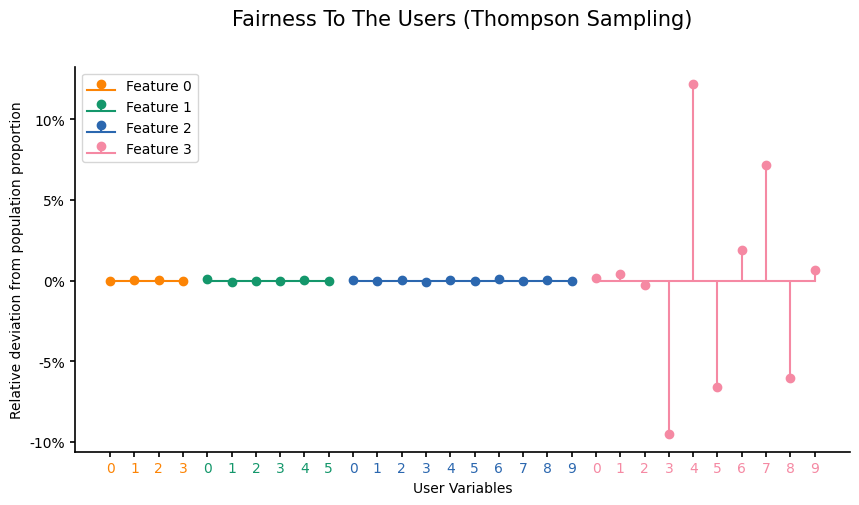

In [565]:
import matplotlib.ticker as mtick

with plt.style.context(myStyle):
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))

    ax.stem([i for i in range(comparisonF0.shape[1])], 
            comparisonF0.iloc[2,:], "#fc8405", basefmt = "#fc8405", label = "Feature 0")
    
    ax.stem([i for i in range(comparisonF0.shape[1], comparisonF1.shape[1] + comparisonF0.shape[1])], 
            comparisonF1.iloc[2,:], "#14976b", basefmt = "#14976b", label = "Feature 1")
    
    ax.stem([i for i in range(comparisonF1.shape[1] + comparisonF0.shape[1], comparisonF2.shape[1] + comparisonF1.shape[1] + comparisonF0.shape[1])], 
            comparisonF2.iloc[2,:], "#2b67af", basefmt = "#2b67af", label = "Feature 2")
    
    ax.stem([i for i in range(comparisonF2.shape[1] + comparisonF1.shape[1] + comparisonF0.shape[1], comparisonF3.shape[1] + comparisonF2.shape[1] + comparisonF1.shape[1] + comparisonF0.shape[1])], 
            comparisonF3.iloc[2,:], "#f589a3", basefmt = "#f589a3", label = "Feature 3")
    
    ax.set_xticks([i for i in range(comparisonF0.shape[1] + comparisonF1.shape[1] + 
                                    comparisonF2.shape[1] + comparisonF3.shape[1])],
                 [i for i in range(comparisonF0.shape[1])] + [i for i in range(comparisonF1.shape[1])] +
                 [i for i in range(comparisonF2.shape[1])] + [i for i in range(comparisonF3.shape[1])])
    
    for i in range(comparisonF0.shape[1]):
        ax.get_xticklabels()[i].set_color("#fc8405")
    for i in range(4, 10):
        ax.get_xticklabels()[i].set_color("#14976b")
    for i in range(10, 20):
        ax.get_xticklabels()[i].set_color("#2b67af")
    for i in range(20, 30):
        ax.get_xticklabels()[i].set_color("#f589a3")
        
    ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10], ["-10%", "-5%", "0%", "5%", "10%"])
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    ax.legend(loc = "upper left")
    ax.set_title(f"Fairness To The Users (Thompson Sampling)", size = 15, pad = 30)
    ax.set_xlabel("User Variables")
    ax.set_ylabel("Relative deviation from population proportion")

    plt.savefig("Thompson_Sampling_Feature_Fairness.png")

    plt.show()